### Feathers in Focus: AML 2025 Kaggle Challenge 🪶
### Athina Papatriantafyllou • Alexandra Holíková • Buğra Sipahioğlu

### Setup Instructions
> **Setup Commands (in terminal):**
> ```bash
> python -m venv venv
> source venv/bin/activate
> pip install -r requirements.txt
> ```
> **Download the data and unzip it under "data/raw":** https://www.kaggle.com/competitions/aml-2025-feathers-in-focus/data

### Import the Libraries

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageStat
from sklearn.model_selection import train_test_split
from torchvision.io import decode_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader

### Define the constants (So that it's easier to change some of them.)

In [2]:
# Data path constants 
DATA_DIR = "../data/raw"
TRAIN_CSV_PATH = f"{DATA_DIR}/train_images.csv"
TEST_CSV_PATH = f"{DATA_DIR}/test_images_path.csv"
CLASS_NAMES_PATH = f"{DATA_DIR}/class_names.npy"
ATTRIBUTES_PATH = f"{DATA_DIR}/attributes.npy"
ATTRIBUTES_TXT_PATH = f"{DATA_DIR}/attributes.txt"
TRAIN_IMAGES_BASE_PATH = f"{DATA_DIR}/train_images"
TEST_IMAGES_BASE_PATH = f"{DATA_DIR}/test_images"

# Dataset constants
VAL_SPLIT_RATIO = 0.2  # 20% validation 80% test for instance. 
RANDOM_STATE = 45  # Keep the same random state across runs for reproducibility
NUM_CLASSES = 200 # It's given in the Kaggle competition description, so we don't need to count it (yet it's counted in EDA part)

# Image transformation constants
IMAGE_SIZE = 224  # Final image size after transformations
RESIZE_SIZE = 256  # Size before center crop for validation/test
RANDOM_CROP_SCALE = (0.7, 1.0)  # RandomResizedCrop scale range
HORIZONTAL_FLIP_PROB = 0.5  # RandomHorizontalFlip probability
ROTATION_DEGREES = 15  # RandomRotation degrees
COLOR_JITTER_BRIGHTNESS = 0.2
COLOR_JITTER_CONTRAST = 0.25
COLOR_JITTER_SATURATION = 0.25
COLOR_JITTER_HUE = 0.15

# Normalization constants (ImageNet normalization statistics since pretrained models are usually trained on ImageNet)
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Device constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE_CPU = 16
BATCH_SIZE_GPU = 32
BATCH_SIZE_MPS = 32
NUM_WORKERS_CPU = 0
NUM_WORKERS_GPU = 0
NUM_WORKERS_MPS = 0
PIN_MEMORY_CPU = False
PIN_MEMORY_GPU = True
PIN_MEMORY_MPS = False

### Load the data

In [3]:
# Load the training and test sets
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
class_names = np.load(CLASS_NAMES_PATH, allow_pickle=True).item()

# Load attributes
attributes = np.load(ATTRIBUTES_PATH, allow_pickle=True)
with open(ATTRIBUTES_TXT_PATH, "r") as f:
    attribute_names = [line.strip().split(' ', 1)[1] for line in f.readlines()]

# Print the data summary
print("Loading the data....")
print(f"-Train Size: {len(train_df)} \n-Test Size: {len(test_df)} \n-Number of Classes: {len(class_names)}")
print(f"-Attributes: {len(attribute_names)} (shape: {attributes.shape if hasattr(attributes, 'shape') else 'N/A'})")


Loading the data....
-Train Size: 3926 
-Test Size: 4000 
-Number of Classes: 200
-Attributes: 312 (shape: (200, 312))


### Explore the data

Random images (with their labels)from the training set:


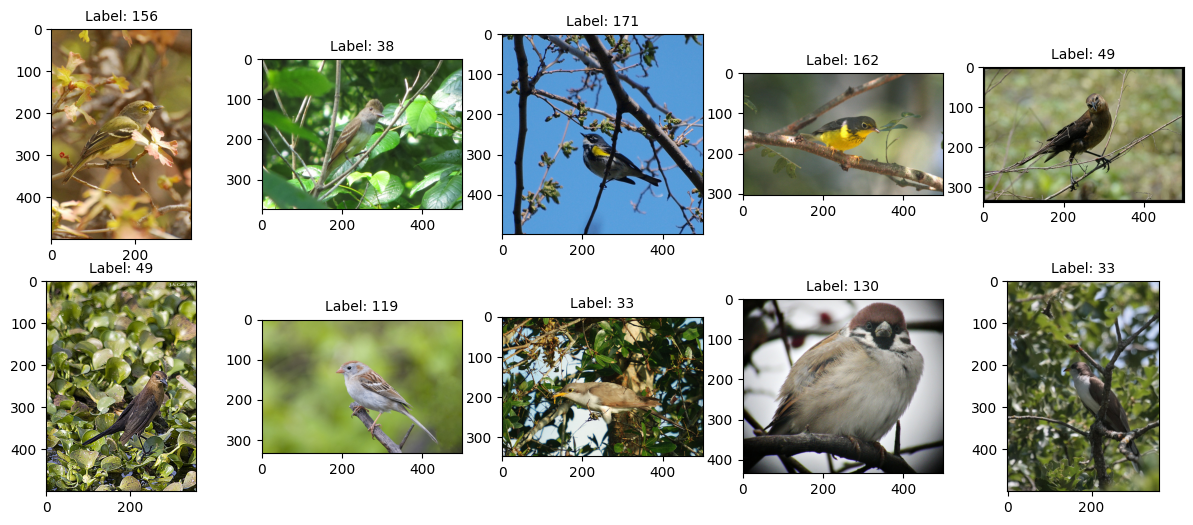

In [4]:
# Inspect the training set by showing 10 random images
print("Random images (with their labels)from the training set:")
samples = train_df.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (_, row) in zip(axes.flat, samples.iterrows()):
    img = Image.open(f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}")
    label_name = class_names.get(row['label'], f"Label: {row['label']}")
    ax.set_title(label_name, fontsize=10)
    ax.imshow(img)
plt.show()

Checking 3926 images' dimensions: 
-Width: min=140, max=500, mean=467.78
-Height: min=120, max=500, mean=385.37


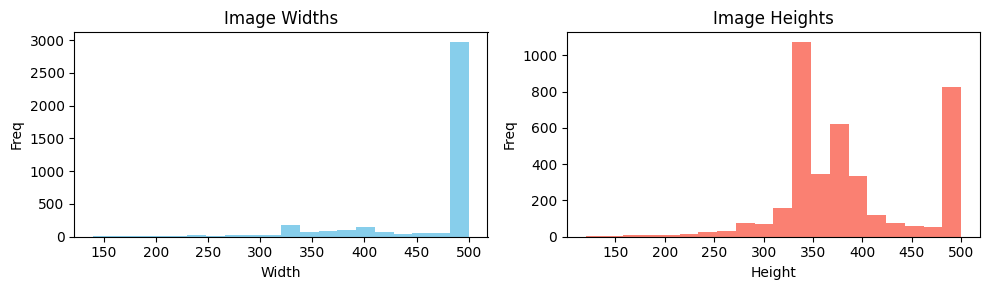

In [5]:
# Check image dimensions in the training set (concise version)
sizes = []
for p in train_df['image_path']:
    sizes.append(Image.open(f"{TRAIN_IMAGES_BASE_PATH}{p}").size)
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]
print(f"Checking {len(widths)} images' dimensions: \n-Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}\n-Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(widths, bins=20, color='skyblue'), axs[0].set(title='Image Widths', xlabel='Width', ylabel='Freq')
axs[1].hist(heights, bins=20, color='salmon'), axs[1].set(title='Image Heights', xlabel='Height', ylabel='Freq')
plt.tight_layout()
plt.show()

In [6]:
# Inspect the attributes
attributes_df = pd.DataFrame({'Index': range(len(attribute_names)), 'Attribute Name': attribute_names})
print("Attributes:")
display(attributes_df.head(10))

Attributes:


,Index,Attribute Name
0,0,has_bill_shape::curved_(up_or_down)
1,1,has_bill_shape::dagger
2,2,has_bill_shape::hooked
3,3,has_bill_shape::needle
4,4,has_bill_shape::hooked_seabird
5,5,has_bill_shape::spatulate
6,6,has_bill_shape::all-purpose
7,7,has_bill_shape::cone
8,8,has_bill_shape::specialized
9,9,has_wing_color::blue


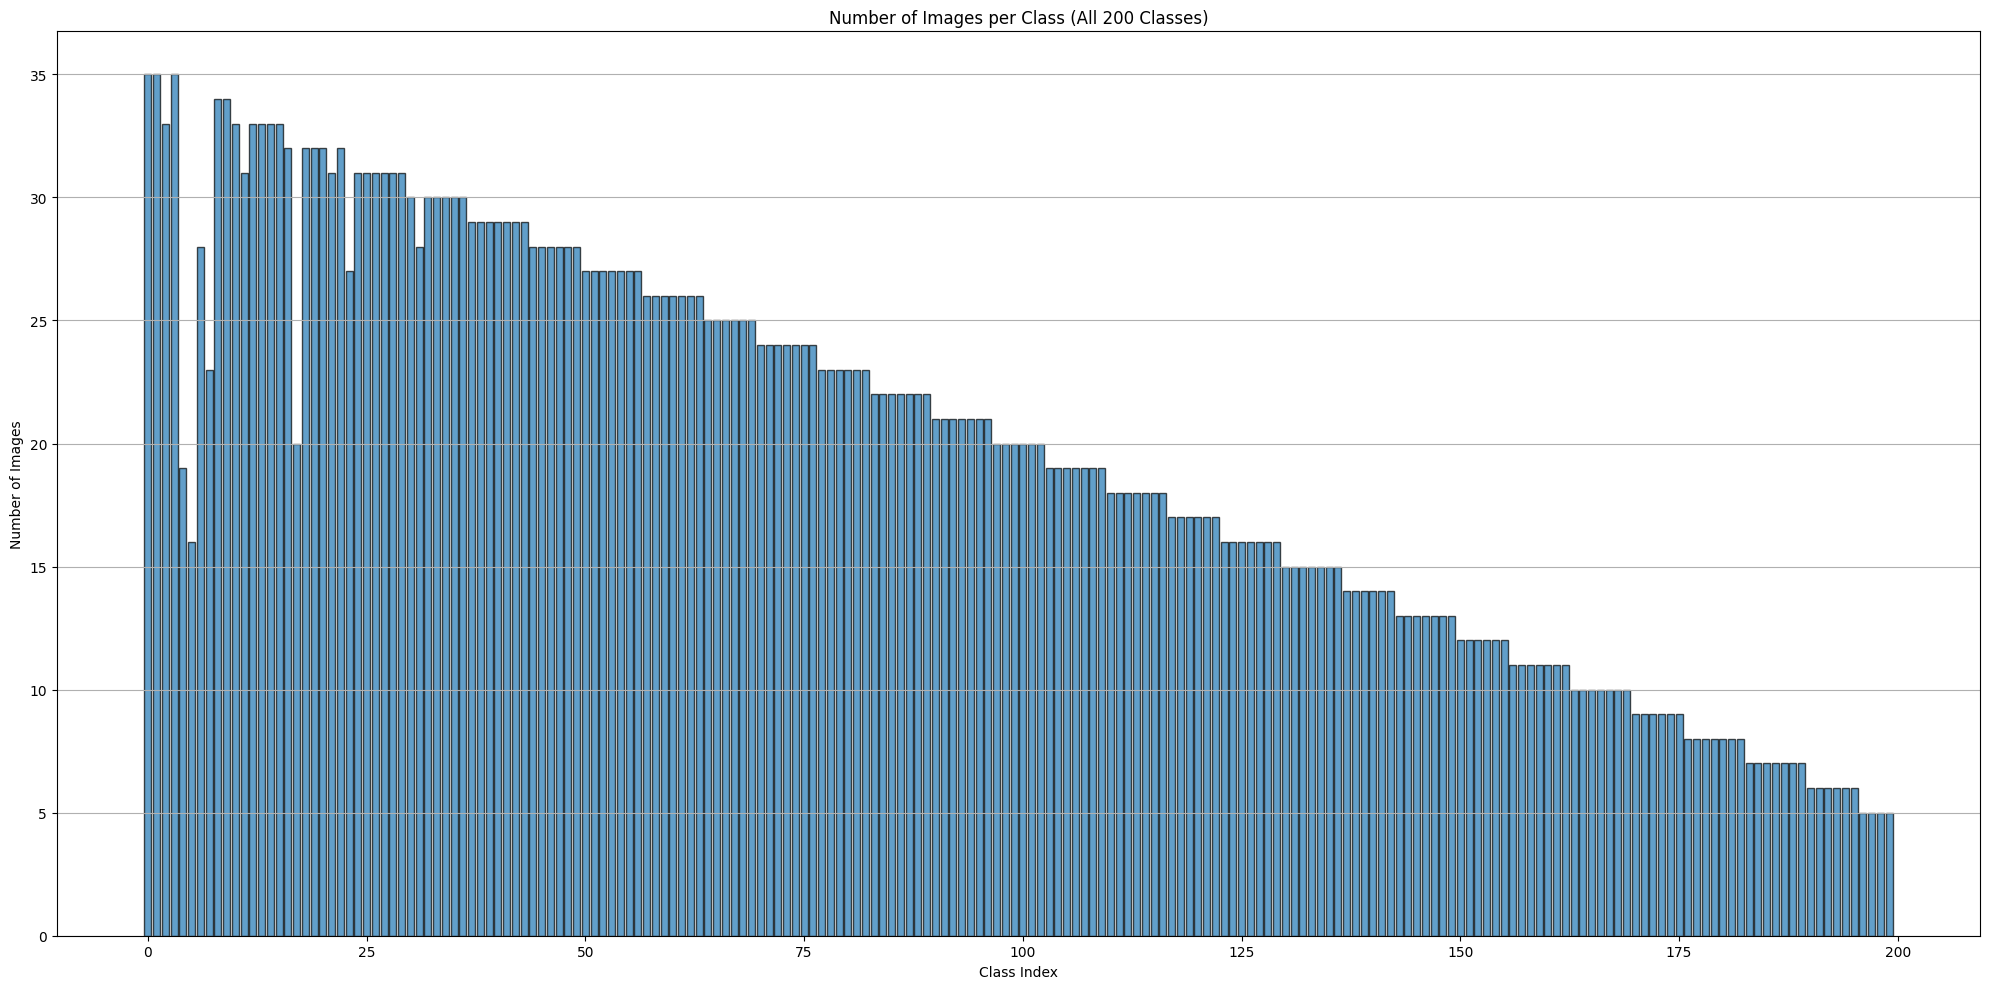

Statistics:
-Number of unique classes: 200
-Average number of images per class: 19.63
-Standard deviation of images per class: 8.39 (Lower the std, more balanced the dataset)
-Minimum number of images per class: 5
-Maximum number of images per class: 35


In [7]:
# Plot the class distribution to inspect the balance
class_counts = train_df['label'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(20, 10))

# Show the count for each class
ax.bar(range(len(class_counts)), class_counts.values, tick_label=None, edgecolor='k', alpha=0.7)
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (All 200 Classes)')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Statistics:")
print(f"-Number of unique classes: {len(class_names)}")
print(f"-Average number of images per class: {class_counts.mean():.2f}")
print(f"-Standard deviation of images per class: {class_counts.std():.2f} (Lower the std, more balanced the dataset)")
print(f"-Minimum number of images per class: {class_counts.min()}")
print(f"-Maximum number of images per class: {class_counts.max()}")


In [8]:
# Check for Corrupted Images

# Check Training Set
corrupt_counter_train = 0
for idx, row in train_df.iterrows():
    img_path = f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_train += 1

# Check Test Set
corrupt_counter_test = 0
for idx, row in test_df.iterrows():
    img_path = f"{TEST_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_test += 1

# Print the results
print(f"Total corrupt images in training set: {corrupt_counter_train}")
print(f"Total corrupt images in test set: {corrupt_counter_test}")


Total corrupt images in training set: 0
Total corrupt images in test set: 0


In [9]:
# Check the color stats for all training images
def get_color_stats(image_path):
    img = Image.open(image_path).convert('RGB')
    stat = ImageStat.Stat(img)
    brightness = sum(stat.mean) / len(stat.mean)
    contrast = sum(stat.stddev) / len(stat.stddev)
    saturation = max(stat.mean) - min(stat.mean)
    return brightness, contrast, saturation

stats = [get_color_stats(f"{TRAIN_IMAGES_BASE_PATH}{p}") for p in train_df['image_path']]
brightnesses = [s[0] for s in stats]
contrasts = [s[1] for s in stats]
saturations = [s[2] for s in stats]

print(f"Color Statistics:")
print(f"- Brightness: mean={np.mean(brightnesses):.2f}, std={np.std(brightnesses):.2f}, range=[{min(brightnesses):.2f}, {max(brightnesses):.2f}]")
print(f"- Contrast: mean={np.mean(contrasts):.2f}, std={np.std(contrasts):.2f}, range=[{min(contrasts):.2f}, {max(contrasts):.2f}]")
print(f"- Saturation: mean={np.mean(saturations):.2f}, std={np.std(saturations):.2f}, range=[{min(saturations):.2f}, {max(saturations):.2f}]")
print("\nWISE WORDS FROM THE ML GODS:")
print("- High variance values indicate that our images already have diverse properties.\n- Hence, we don't need to use (high parameters for) ColorJitter.")

Color Statistics:
- Brightness: mean=121.81, std=33.72, range=[18.69, 244.95]
- Contrast: mean=47.22, std=14.21, range=[11.51, 106.21]
- Saturation: mean=32.34, std=25.01, range=[0.00, 178.80]

WISE WORDS FROM THE ML GODS:
- High variance values indicate that our images already have diverse properties.
- Hence, we don't need to use (high parameters for) ColorJitter.


### Split the data into training, validation and test sets

In [10]:
# Extract image paths and labels
X = train_df['image_path'].values
y = train_df['label'].values       

# Look at indices of labels (Y)
print("Before correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Since the labels start from 1, convert them to 0-indexed
y = y - 1

print("After correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Split the data into training and validation sets (80% train, 20% validation)
X_test = test_df['image_path'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size = VAL_SPLIT_RATIO, 
    random_state = RANDOM_STATE, # keep the same random state across runs for reproducibility
    stratify = y  # Maintains class distribution in both sets
)

Before correction:
- y indices min: 1
- y indices max: 200
After correction:
- y indices min: 0
- y indices max: 199


### Define the transformations

In [11]:
# Transformations for training set
transformation_training = v2.Compose([

    # Randomly crop to IMAGE_SIZE from a resized area of the image.
    # - Scale controls how much of the original image area we keep (tunable via RANDOM_CROP_SCALE).
    # - Since feathers require fine details, we keep the scale high.
    # - Antialias=True is used to improve the quality of the resized image.
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=RANDOM_CROP_SCALE, antialias=True),
    
    # Random horizontal flip (tunable via HORIZONTAL_FLIP_PROB)
    v2.RandomHorizontalFlip(p=HORIZONTAL_FLIP_PROB), 
    
    # Random rotation (tunable via ROTATION_DEGREES)
    v2.RandomRotation(degrees=ROTATION_DEGREES), 
    
    # Color jitter (tunable via COLOR_JITTER constants)
    # Kept small since the stats of the training images are already diverse.
    # Strong color augmentations can distort the images and make the model more confused.
    v2.ColorJitter(
        brightness=COLOR_JITTER_BRIGHTNESS, 
        contrast=COLOR_JITTER_CONTRAST, 
        saturation=COLOR_JITTER_SATURATION, 
        hue=COLOR_JITTER_HUE
    ), 
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
    
    # Normalize the image (ImageNet stats for pretrained models, tunable)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD), 
])

# Transformations for validation set
transformation_validation = v2.Compose([
    
    # Resize to RESIZE_SIZE (no randomness for consistent validation)
    v2.Resize(RESIZE_SIZE, antialias=True),

    # Center crop to IMAGE_SIZE (matches the training set)
    v2.CenterCrop(IMAGE_SIZE),
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
     
    # Normalize the image (must match the training normalization)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

### Create Custom Dataset for PyTorch

In [12]:
# Pytorch needs a custom dataset to load and transform the data
class FeatherImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transformation=None, target_transformation=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transformation = transformation
        self.target_transformation = target_transformation
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, i):
        image_path = self.image_paths[i]
        image_label = self.image_labels[i]  
        image = decode_image(image_path)
        if self.transformation:
            image = self.transformation(image)
        if self.target_transformation:
            image_label = self.target_transformation(image_label)
        return image, image_label

### Create Dataset Instances and DataLoaders

In [13]:
# Create dataset instances with transformations
# Create custom dataset instance for training set
train_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    image_labels = y_train,
    transformation = transformation_training
)

# Create custom dataset instance for validation set
val_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_val],
    image_labels = y_val,
    transformation = transformation_validation
)

# Check device availability
# - If GPU is available, use it
# - If MPS is available, use it (GPU supportfor Apple Silicon)
# - Otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
if device.type == 'cuda':
    batch_size = BATCH_SIZE_GPU
    num_workers = NUM_WORKERS_GPU # Set to 0 for Jupyter notebooks as they might fail with too many workers
    pin_memory = PIN_MEMORY_GPU  # FYI: Pin memory speeds up the transfer data from CPU RAM to GPU vRAM
elif device.type == 'mps':
    batch_size = BATCH_SIZE_MPS
    num_workers = NUM_WORKERS_MPS
    pin_memory = PIN_MEMORY_MPS  # MPS doesn't support pin_memory
else:
    batch_size = BATCH_SIZE_CPU
    num_workers = NUM_WORKERS_CPU
    pin_memory = PIN_MEMORY_CPU  # Not needed for CPU (since it's used to speed up the transfer data from CPU RAM to GPU vRAM)

# Print the DataLoader configuration
print("DataLoader configuration:")
print(f"- Using device: {device}")
print(f"- Batch size: {batch_size}")
print(f"- Number of workers: {num_workers} (0 = main process, avoids pickling issues in Jupyter)")
print(f"- Pin memory: {pin_memory}")

# Create DataLoader for training set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle training data so that the model doesn't memorize the order of the data
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Create DataLoader for validation set
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle validation data: So that each time we use the validation, it's the same
    num_workers=num_workers,
    pin_memory=pin_memory  
)

# Print the final information
print(f"\nSetup:")
print(f"- Train dataset: {len(train_dataset)} samples")
print(f"- Validation dataset: {len(val_dataset)} samples")
print(f"- Batch size: {batch_size}")

DataLoader configuration:
- Using device: mps
- Batch size: 32
- Number of workers: 0 (0 = main process, avoids pickling issues in Jupyter)
- Pin memory: False

Setup:
- Train dataset: 3140 samples
- Validation dataset: 786 samples
- Batch size: 32


### Model Training (You can check the sample demonstration for how to use train_loader and val_loader)

### Pretrained Model for Baseline

Saw this somewhere and implemented it \
Not sure yet if we will keep it \
No need to look ar it now

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Load pre-trained ResNet50
#model = resnet50(pretrained=True)
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 200)  # 200 bird species


/Users/athob/Library/CloudStorage/OneDrive-UvA/Machine Learning/Group Project/aml-2025-feathers/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/athob/Library/CloudStorage/OneDrive-UvA/Machine Learning/Group Project/aml-2025-feathers/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model

In [40]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 4.860614665830978
Epoch 2/10, Loss: 4.867880618933476
Epoch 3/10, Loss: 4.870941860507233
Epoch 4/10, Loss: 4.860663664461386
Epoch 5/10, Loss: 4.859873227398805
Epoch 6/10, Loss: 4.873609643993956
Epoch 7/10, Loss: 4.853660130741621
Epoch 8/10, Loss: 4.865556052236846
Epoch 9/10, Loss: 4.854360450397838
Epoch 10/10, Loss: 4.847009822575733


Validate the model

In [41]:
def validate(model, val_loader, criterion=None):
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0 if criterion else None

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if criterion: # If loss function is defined
                loss = criterion(outputs, labels)
                val_loss += loss.item()

    acc = correct / total # Calculate accuracy over entire validation set

    if criterion:
        return acc, val_loss / len(val_loader) # Average loss per batch
    return acc


val_acc, val_loss = validate(model, val_loader, criterion)  # Gets both values
print(f"Results: Val Acc: {val_acc:.3f} ({val_acc*100:.1f}%), Val Loss: {val_loss:.4f}")

Results: Val Acc: 0.027 (2.7%), Val Loss: 4.9651


### Hugging face for Baseline

In [45]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="Emiel/cub-200-bird-classifier-swin")
pipe("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/parrots.png")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


[{'label': 'Pacific_Loon', 'score': 0.045932307839393616},
 {'label': 'Ovenbird', 'score': 0.029305577278137207},
 {'label': 'Hooded_Oriole', 'score': 0.02916361205279827},
 {'label': 'Black_Tern', 'score': 0.025951217859983444},
 {'label': 'Rufous_Hummingbird', 'score': 0.023637685924768448}]

In [46]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("Emiel/cub-200-bird-classifier-swin")
model = AutoModelForImageClassification.from_pretrained("Emiel/cub-200-bird-classifier-swin")

In [49]:
class FeatherImageDatasetHF(Dataset):
    def __init__(self, image_paths, image_labels=None, processor=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = decode_image(self.image_paths[i])
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add labels only for train/val
        if self.image_labels is not None:
            inputs["labels"] = torch.tensor(self.image_labels[i], dtype=torch.long)
        
        return inputs


In [50]:
def validate_hf(model, val_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            # Move all inputs to device
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")  # remove labels
            
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


In [51]:
train_dataset_hf = FeatherImageDatasetHF(
    [TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    y_train,
    processor
)

val_dataset_hf = FeatherImageDatasetHF(
    [TRAIN_IMAGES_BASE_PATH + path for path in X_val],
    y_val,
    processor
)

train_loader_hf = DataLoader(train_dataset_hf, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, pin_memory=pin_memory)

val_loader_hf = DataLoader(val_dataset_hf, batch_size=batch_size, shuffle=False, 
                           num_workers=num_workers, pin_memory=pin_memory)

acc = validate_hf(model, val_loader_hf, device)
print(f"HF Swin validation accuracy: {acc:.3f} ({acc*100:.1f}%)")


HF Swin validation accuracy: 0.981 (98.1%)


### Our model - 2nd try

CNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyBirdCNN(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        # Takes 3-channel RGB image input.
        # 32 filters = the model will learn 32 different edge/texture detectors.
        # Padding=1 keeps the spatial dimensions same after convolution.

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Even deeper features (feather patterns, shapes, edges, etc.)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 3 → 32
        x = self.pool(F.relu(self.conv2(x)))   # 32 → 64
        x = self.pool(F.relu(self.conv3(x)))   # 64 → 128
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [62]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


In [63]:
def validate(model, loader, device):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

    return correct / len(loader.dataset)


In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyBirdCNN(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10
  Loss: 5.2764 | Val Acc: 0.0178
Epoch 2/10
  Loss: 5.1476 | Val Acc: 0.0280
Epoch 3/10
  Loss: 4.9867 | Val Acc: 0.0344
Epoch 4/10
  Loss: 4.8249 | Val Acc: 0.0407
Epoch 5/10
  Loss: 4.6417 | Val Acc: 0.0585
Epoch 6/10
  Loss: 4.4763 | Val Acc: 0.0598
Epoch 7/10
  Loss: 4.3209 | Val Acc: 0.0751
Epoch 8/10
  Loss: 4.1712 | Val Acc: 0.0738
Epoch 9/10
  Loss: 4.0547 | Val Acc: 0.0929
Epoch 10/10
  Loss: 3.9123 | Val Acc: 0.0967
